In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
cwd = os.getcwd()
test_set = pd.DataFrame(pd.read_csv(os.path.join(cwd, 'datasets/test_data.csv')))
dataset = pd.DataFrame(pd.read_csv(os.path.join(cwd, 'datasets/train_data.csv')))

In [3]:
dataset.head()

,ID,parents,has_nurs,form,children,housing,finance,social,health,app_status
0,1,usual,less_proper,complete,3,critical,convenient,problematic,not_recom,0
1,2,pretentious,very_crit,completed,1,convenient,inconv,nonprob,not_recom,0
2,3,pretentious,proper,incomplete,1,less_conv,convenient,slightly_prob,priority,1
3,4,great_pret,improper,complete,1,convenient,convenient,nonprob,recommended,1
4,5,great_pret,less_proper,completed,1,convenient,convenient,slightly_prob,priority,1


In [4]:
dataset.shape

(10368, 10)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10368 entries, 0 to 10367
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          10368 non-null  int64 
 1   parents     10368 non-null  object
 2   has_nurs    10368 non-null  object
 3   form        10368 non-null  object
 4   children    10368 non-null  object
 5   housing     10368 non-null  object
 6   finance     10368 non-null  object
 7   social      10368 non-null  object
 8   health      10368 non-null  object
 9   app_status  10368 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 810.1+ KB


In [6]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        2592 non-null   int64 
 1   parents   2592 non-null   object
 2   has_nurs  2592 non-null   object
 3   form      2592 non-null   object
 4   children  2592 non-null   object
 5   housing   2592 non-null   object
 6   finance   2592 non-null   object
 7   social    2592 non-null   object
 8   health    2592 non-null   object
dtypes: int64(1), object(8)
memory usage: 182.4+ KB


In [7]:
dataset[dataset.isnull().any(axis=1)]    # any null records available?
del dataset['ID']
del test_set['ID']

### Label Encoding

In [8]:
label_encoder = preprocessing.LabelEncoder()

In [9]:
# Label Encoding for ordinal columns
def clean_ordinal(dataset):
    columns_ordinal = ['parents', 'has_nurs', 'children', 'housing', 'social', 'health', 'finance']

    for column in columns_ordinal:
        dataset[column] = label_encoder.fit_transform(dataset[column])
    return dataset

### One Hot Encoding

In [10]:
onehot_encoder = preprocessing.OneHotEncoder(drop='first')

In [11]:
# OneHotEncoding for nominal columns
def clean_nominal(dataset):
    columns_nominal = ['form']

    cleaned_dataset = dataset

    for column in columns_nominal:
        X = onehot_encoder.fit_transform(dataset[column].values.reshape(-1, 1)).toarray()
        # create dataframe from encoded data
        dataset_onehot = pd.DataFrame(X, columns = [column + '_' + str(i) for i in range(X.shape[1])]) 
        # update dataset -> cleaned_dataset
        cleaned_dataset = pd.concat([dataset_onehot, cleaned_dataset], axis=1)
        # remove encoded column from dataset
        del cleaned_dataset[column]
    return cleaned_dataset

In [12]:
# Test set cleaning
test_set = clean_ordinal(test_set)
cleaned_test_set = clean_nominal(test_set)
cleaned_test_set.head()

,form_0,form_1,form_2,parents,has_nurs,children,housing,finance,social,health
0,0.0,0.0,0.0,2,3,0,0,0,0,2
1,0.0,0.0,0.0,2,3,0,0,1,0,1
2,0.0,0.0,0.0,2,3,0,0,1,1,1
3,0.0,0.0,0.0,2,3,0,2,0,1,2
4,0.0,0.0,0.0,2,3,0,2,0,1,1


In [13]:
cleaned_dataset = clean_nominal(clean_ordinal(dataset))
cleaned_dataset.head()

,form_0,form_1,form_2,parents,has_nurs,children,housing,finance,social,health,app_status
0,0.0,0.0,0.0,2,2,2,1,0,1,0,0
1,1.0,0.0,0.0,1,4,0,0,1,0,0,0
2,0.0,0.0,1.0,1,3,0,2,0,2,1,1
3,0.0,0.0,0.0,0,1,0,0,0,0,2,1
4,1.0,0.0,0.0,0,2,0,0,0,2,1,1


### Independant dependant var splitting

In [14]:
x = cleaned_dataset.iloc[:, 0:-1]
y = cleaned_dataset.iloc[:, -1]

In [15]:
x.shape

(10368, 10)

### Normalizing

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 

x = scaler.fit_transform(x)

### Test train split

In [17]:
# splitting dataset to training and testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

### Classifier

In [18]:
x_train.shape

(7257, 10)

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [20]:
activation = 'relu'
optimizer = 'nadam'
init = 'uniform'

In [21]:
def build_model():
    classifier = Sequential()

    classifier.add(Dense(256, input_dim=10, activation=activation, kernel_initializer=init))
    classifier.add(Dropout(0.3))
    classifier.add(Dense(128, input_dim=10, activation=activation, kernel_initializer=init))
    classifier.add(Dropout(0.3))
    classifier.add(Dense(128, input_dim=10, activation=activation, kernel_initializer=init))
    classifier.add(Dropout(0.3))
    classifier.add(Dense(1, activation='sigmoid', kernel_initializer=init))
    # Compile model
    classifier.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return classifier

In [22]:
classifier = build_model()

In [23]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [24]:
history = classifier.fit(x, y, batch_size=10, epochs=50, validation_split=0.1, verbose = 1, shuffle=True )

Epoch 1/50
934/934 [==============================] - 2s 2ms/step - loss: 0.4490 - accuracy: 0.7725 - val_loss: 0.2528 - val_accuracy: 0.8939
Epoch 2/50
934/934 [==============================] - 1s 1ms/step - loss: 0.2463 - accuracy: 0.8871 - val_loss: 0.1805 - val_accuracy: 0.9219
Epoch 3/50
934/934 [==============================] - 1s 1ms/step - loss: 0.1747 - accuracy: 0.9221 - val_loss: 0.1311 - val_accuracy: 0.9489
Epoch 4/50
934/934 [==============================] - 1s 1ms/step - loss: 0.1467 - accuracy: 0.9408 - val_loss: 0.1248 - val_accuracy: 0.9421
Epoch 5/50
934/934 [==============================] - 1s 1ms/step - loss: 0.1223 - accuracy: 0.9494 - val_loss: 0.1071 - val_accuracy: 0.9547
Epoch 6/50
934/934 [==============================] - 1s 1ms/step - loss: 0.1200 - accuracy: 0.9467 - val_loss: 0.0941 - val_accuracy: 0.9537
Epoch 7/50
934/934 [==============================] - 1s 1ms/step - loss: 0.1090 - accuracy: 0.9535 - val_loss: 0.0768 - val_accuracy: 0.9672
Epoch 

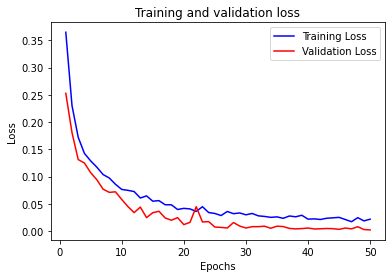

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

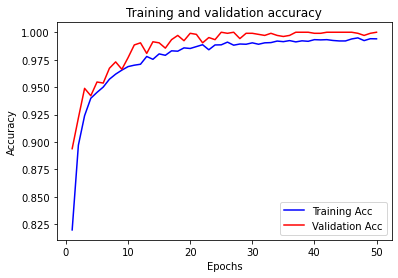

In [26]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, 'b', label='Training Acc')
plt.plot(epochs, val_accuracy, 'r', label='Validation Acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


In [28]:
from sklearn.model_selection import cross_val_score

model = KerasClassifier(build_model)

accuracies = cross_val_score(estimator=model, X=x, y=y, cv=5)

65/65 [==============================] - 0s 514us/step - loss: 0.3078 - accuracy: 0.8611


In [29]:
mean = accuracies.mean()
variance = accuracies.std()

In [30]:
print(mean, variance)

0.8452965378761291 0.016369538234827303


In [31]:
from sklearn import metrics
y_pred = (classifier.predict(x_test) > 0.5)

print('Accuracy', metrics.accuracy_score(y_test, y_pred))
# # for tanh, sigmoid, binarycrossentropy -> 96.88%
# loss, accuracy = classifier.evaluate(x_test,y_test)

Accuracy 1.0


In [32]:
# epoch 50
# act = tanh -> init = uniform |optimizer = adam  -> Accuracy 0.9697846351655416 -> cm(30, 64) -> f1 = 97
# act = tanh -> init = uniform |optimizer = nadam  -> Accuracy 0.9588556734169077 -> cm(1, 127) -> f1 = 96
## epoch 50
# act = relu -> init =uniform | optimizer = adam -> Accuracy 0.973963355834137 -> cm(14, 67) -> f1 = 97 ***
# act = relu -> init =uniform | optimizer = nadam -> Accuracy 0.9713918354226937 -> cm(58, 31) -> f1 = 97 ***
# act = relu -> init =he_uniform | optimizer = adam -> Accuracy 0.9697846351655416 -> cm(39, 55) -> f1 = 97
###
# n = 15
# act = softsign -> init =uniform | optimizer = nadam ->Accuracy 0.9681774349083896 -> cm(42, 57) -> f1 = 97
# act = softsign -> init =he_uniform | optimizer = nadam ->Accuracy 0.9704275152684024 -> cm(47, 45) -> f1 = 97
# n = 22
# act = softsign -> init =he_uniform | optimizer = nadam ->Accuracy 0.9707489553198329 -> cm(28, 63) -> f1 = 97 
# same with epoch 100, batch 40


### Confusion matrix

In [33]:
from sklearn.metrics import confusion_matrix

predict_class = classifier.predict(x_test)
predict_class = (predict_class> 0.5)
predict_class

array([[ True],
       [ True],
       [False],
       ...,
       [False],
       [ True],
       [False]])

In [34]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[2051,    0],
       [   0, 1060]], dtype=int64)

### Classification report

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2051
           1       1.00      1.00      1.00      1060

    accuracy                           1.00      3111
   macro avg       1.00      1.00      1.00      3111
weighted avg       1.00      1.00      1.00      3111



### ROC-AUC

In [36]:
y_pred_proba = classifier.predict_proba(x_test)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

C:\Users\ACER\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


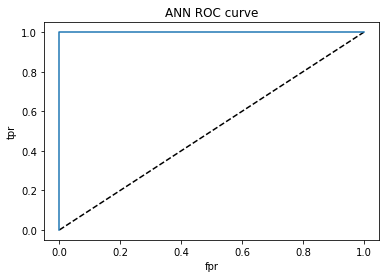

In [37]:
import matplotlib.pyplot as plt

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ANN ROC curve')
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

1.0

### New prediction

In [39]:
cleaned_test_set = scaler.fit_transform(cleaned_test_set)

In [40]:
cleaned_test_set.shape

(2592, 10)

In [41]:
predict = classifier.predict(cleaned_test_set)
predict = (predict > 0.5).flatten()
arr = predict.astype(int)
print(arr)
np.savetxt("predicted/pred_ann_64_0_2.csv", np.dstack((np.arange(1, arr.size+1),arr))[0],"%d,%d",header="ID,app_status")

[1 1 1 ... 0 0 0]
